In [12]:
import pandas as pd
import numpy as np
import glob
import cv2

from google.colab.patches import cv2_imshow
import datetime
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
import random

import torch #ML
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import Subset

import albumentations as A #augmentation(増強)
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm, trange #残り何秒か分かる
from typing import OrderedDict #辞書型に順番を決める
from sklearn.model_selection import KFold

from google.colab import drive
drive.mount('/content/drive')

DIR_PATH="/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
patch_size = 112

In [3]:
def make_augmentations(W=patch_size, H=patch_size, crop_size=patch_size):
    augmentations_dict = {

        "vertical_flip": A.Compose(
            [
                A.VerticalFlip(p=1.0),
            ]
        ),

        "horizontal_flip":A.Compose(
            [
                A.HorizontalFlip(p=1.0),
            ]
        ),

        "normallize": A.Compose(
            [
                ToTensorV2(),
            ]
        ),
    }
    return augmentations_dict

In [4]:
class Transform(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

class Transform_horizontal(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["horizontal_flip"](image=image)["image"]
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

class Transform_vertical(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["vertical_flip"](image=image)["image"]
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

class Transform_inverted(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["horizontal_flip"](image=image)["image"]
          image = self.augmentations_dict["vertical_flip"](image=image)["image"]
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

In [13]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self,transform):
    self.transform = transform
    self.images = []
    self.labels = []
    self.mu_range = [1e20,0]
    self.n_range = [1e20,0]
    self.conditions = []
    sample_paths=glob.glob(f"{DIR_PATH}/*")

    for path in tqdm(sample_paths):
      sample_name=path.split("/")[-1]

      path_dict={
      key:f"{DIR_PATH}/{sample_name}/{sample_name}_{key}.bmp"
        for key in ["BC","GB","IPF"]
      }
      print(path_dict)
      image = np.dstack([cv2.imread(path) for path in path_dict.values()])

      path_dict["Hall"]=f"{DIR_PATH}/{sample_name}/{sample_name}_Hall.csv" #DFに一列だけ追加するみたいなもん
      Hall=pd.read_csv(path_dict["Hall"])
      mu=Hall["Mobility [cm²/(V·s)]"].tolist()
      n=Hall["Carrier Concentration [1/cm³]"].tolist()

      if self.mu_range[0] > np.min(mu):
        self.mu_range[0] = np.min(mu)
      if self.mu_range[1] < np.max(mu):
        self.mu_range[1] = np.max(mu)

      if self.n_range[0] > np.min(n):
        self.n_range[0] = np.min(n)
      if self.n_range[1] < np.max(n):
        self.n_range[1] = np.max(n) # imageは結合した画像

      H,W,_ = image.shape #3変数返ってくるので
      n_H, n_W = H//patch_size, W//patch_size
      H_, W_ = patch_size*n_H, patch_size*n_W
      image = image[:H_, :W_]

      for h in np.vsplit(image, n_H):
        for w in np.hsplit(h, n_W):
          self.images.append(w)
          label=[random.choice(mu),random.choice(n)]
          self.labels.append(label)

    self.labels=np.array(self.labels)
    self.labels=(self.labels-np.min(self.labels,axis=0))/(np.max(self.labels,axis=0)-np.min(self.labels,axis=0))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image=self.images[idx]
    for num in range(2):
      image=self.transform(image)
      image=image.to(torch.float32)

      label=self.labels[idx]
      label=torch.Tensor(label)
      label=label.to(torch.float32)
      return image, label

In [14]:
trans = Transform(augmentations_dict=make_augmentations())
trainval_dataset = CustomDataset(trans)
mu_range = trainval_dataset.mu_range
n_range = trainval_dataset.n_range

trans = Transform_horizontal(augmentations_dict=make_augmentations())
trainval_dataset += CustomDataset(trans)

trans = Transform_vertical(augmentations_dict=make_augmentations())
trainval_dataset += CustomDataset(trans)

trans = Transform_inverted(augmentations_dict=make_augmentations())
trainval_dataset += CustomDataset(trans)

  0%|          | 0/7 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04

  0%|          | 0/7 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04

  0%|          | 0/7 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04

  0%|          | 0/7 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge39/SPC-Ge39_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge38/SPC-Ge38_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/00.データ/01.学習データ/01.n型/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04

In [15]:
count = 0
for i,_ in trainval_dataset:
  count += 1
print(count)

2160


In [16]:
from torchvision import models
class ResNetBaseModel(nn.Module):
  def __init__(
       self,
       num_layer: int,
       pretrained: bool = True,
       is_BC=True,
       is_GB=True,
       is_IPF=True,
    ):
       super().__init__()
       if num_layer in [18, 34, 50, 101, 152]:
         if num_layer == 18:
            self.resnet = models.resnet18(pretrained=pretrained)
         elif num_layer == 34:
            self.resnet = models.resnet34(pretrained=pretrained)
         elif num_layer == 50:
            self.resnet = models.resnet50(pretrained=pretrained)
         elif num_layer == 101:
            self.resnet = models.resnet101(pretrained=pretrained)
         elif num_layer == 152:
            self.resnet = models.resnet152(pretrained=pretrained)
         self.out = nn.Sequential(
             nn.Linear(self.resnet.fc.in_features, 2), #MSEと組み合わせが良い、rangeは勝手に学習する
             nn.Sigmoid()
         )
         self.resnet.conv1 = nn.Conv2d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
         self.resnet.fc = nn.Identity()

       else:
         raise Exception("Invalid number of ResNet layers.")

       self.is_BC=is_BC
       self.is_GB=is_GB
       self.is_IPF=is_IPF

  def forward(self, x):
    x=self.channel_setting(x)
    features = self.resnet(x)
    output = self.out(features)
    return output

  def get_features(self, x):
    features = self.resnet(x)
    return features

  def channel_setting(self,x):
    if not self.is_BC:
      x[:,0] = 0
      x[:,1] = 0
      x[:,2] = 0
    if not self.is_GB:
      x[:,3] = 0
      x[:,4] = 0
      x[:,5] = 0
    if not self.is_IPF:
      x[:,6] = 0
      x[:,7] = 0
      x[:,8] = 0
    return x

  def predict(self, sample_path, device, mu_range, n_range, corner):
    self.eval()
    self.to(device)
    sample_name=sample_path.split("/")[-1]

    path_dict={
        key:f"{sample_path}/{sample_name}_{key}.bmp"
        for key in ["BC","GB","IPF"]
    }
    print(path_dict)

    image = np.dstack([cv2.imread(path) for path in path_dict.values()])
    image=image[corner[0]:corner[0]+patch_size,corner[1]:corner[1]+patch_size]

    aug = A.Compose(
        [
             ToTensorV2(),
         ]
         )

    with torch.no_grad():
      x = aug(image=image)["image"]
      x = x/255
      x = x.unsqueeze(0)
      x = x.to(torch.float32)
      x = x.to(device)
      y = self.forward(x)
      mu = y[0][0].item()*(mu_range[1]-mu_range[0])+mu_range[0]
      n = y[0][1].item()*(n_range[1]-n_range[0])+n_range[0]
      return mu, n

In [31]:
num_start=0
batch_size=32
num_layer = 152
num_epoch=50
random_state=0
lr=5e-5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

num_loop=0

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
for k, (train_idx, valid_idx) in enumerate(kf.split(trainval_dataset)):
  best_loss=1
  if num_loop>=num_start:
    print(f"try_{num_loop}:k={k}")
    train_dataset = Subset(trainval_dataset, train_idx)
    val_dataset   = Subset(trainval_dataset, valid_idx)

    # 学習用Dataloader
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size, #同時に学習する問題数、大きいほうが良いがスペックと相談
        shuffle=True,
        num_workers=8,
        drop_last=True, #8,8,8,3とかが嫌なので3を除く
        pin_memory=True
    )

  #評価用Dataloader
  valid_dataloader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=8,
      drop_last=False,
      pin_memory=True
  )

  model = ResNetBaseModel(num_layer)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.to(device) #作った計算をどっちでやるか記載するだけ Returnがmodelになる

  train_loss=[]
  valid_loss=[]

  with trange(num_epoch) as pbar:
    for i in pbar:
      pbar.set_description(f'[Epoch {i + 1}/{num_epoch}]')
      model.train()
      running_loss=[]

      for image, label in train_dataloader:
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
      train_loss.append(np.mean(running_loss))

      model.eval()#評価モード
      running_loss=[]
      with torch.no_grad():
        for image, label in valid_dataloader:
          image, label = image.to(device), label.to(device)
          outputs = model(image)
          loss = criterion(outputs, label)
          running_loss.append(loss.item())
      valid_loss.append(np.mean(running_loss))

      pbar.set_postfix(
          OrderedDict(
              TrainLoss=train_loss[-1],
              ValidLoss=valid_loss[-1],
          )
      )
      if best_loss>valid_loss[-1]:
        best_loss=valid_loss[-1]
        torch.save(model.state_dict(), f"/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/ResNet{num_layer}_patch{patch_size}_lr={lr}_k={k}__GB赤_TB青.pth")
  num_loop+=1
  print(best_loss)
  pd.DataFrame(data={
    "train_loss":train_loss,
    "valid_loss":valid_loss,
  }).to_csv(f"/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/ResNet{num_layer}_patch{patch_size}_lr={lr}_k={k}_GB赤_TB青.csv",index=False)

try_0:k=0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can al

  0%|          | 0/50 [00:00<?, ?it/s]

0.0016885645673028193
try_1:k=1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can al

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [18]:
model = ResNetBaseModel(152)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/02.電気特性/ResNet152_patch112_lr=5e-05_k=0__GB赤_TB青.pth'))

<All keys matched successfully>

In [19]:
def list_average(x):
  mob_ave = 0
  n_ave = 0
  for i in range(len(x)):
    mob_ave += x[i][0]
    n_ave   += x[i][1]
  mob_ave = mob_ave/len(x)
  n_ave = n_ave/len(x)
  return mob_ave, n_ave

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


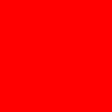

(280.2836010630628, 5.269723985847058e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


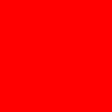

(284.6214603264354, 5.343370293122866e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


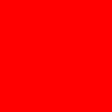

(284.50827837631033, 5.352294899545928e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


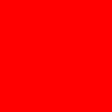

(285.3870093676879, 5.365100465071606e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


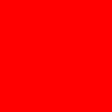

(284.3110013081014, 5.346373097086339e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


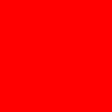

(284.4995381533634, 5.342822178332324e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


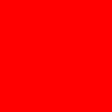

(264.3511037716667, 5.049500339177864e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


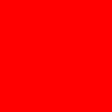

(285.34913506825126, 5.364102909669831e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


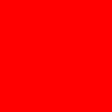

(283.31053712144535, 5.323186016649957e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


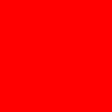

(278.5973994565866, 5.240157101566308e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


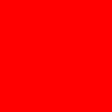

(284.7262170166027, 5.352004058528835e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


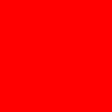

(277.4662413776126, 5.200245198304186e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


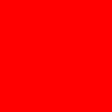

(281.00280330047246, 5.295340298419244e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


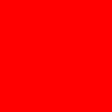

(278.4443116957453, 5.25596502048843e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


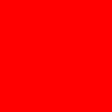

(277.36573668779795, 5.202859613488828e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


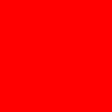

(285.09284968403864, 5.358549896323319e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


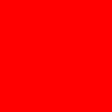

(283.1183309573606, 5.325325308902726e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


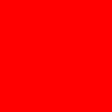

(284.55038892795, 5.345228206266145e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


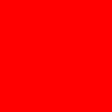

(284.5398691641148, 5.347008396596955e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


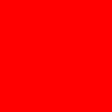

(281.7750453052428, 5.299018727642411e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


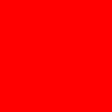

(276.5002183938122, 5.219009512785814e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


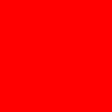

(284.8959190751178, 5.352524012880076e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


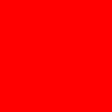

(283.54126325909425, 5.33357564176718e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


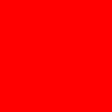

(284.9590691544279, 5.355742413166833e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


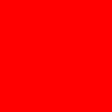

(283.9294236468337, 5.335606122082492e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


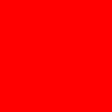

(284.57007411476735, 5.344224568209482e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


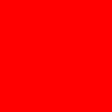

(280.43265729764386, 5.261809100135549e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


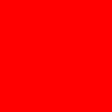

(279.3347435621671, 5.246058853793114e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


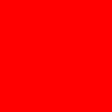

(283.74696558726095, 5.335467122154106e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


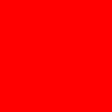

(283.63425608161947, 5.324514964101419e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


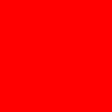

(281.5298938626941, 5.268090004517095e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


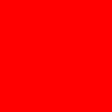

(285.473545448937, 5.366923233986638e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


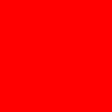

(279.600651065696, 5.257909667784753e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


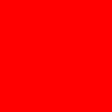

(284.7930049184366, 5.35276168698777e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


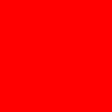

(278.0449071292958, 5.210853123146865e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


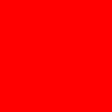

(282.75097387504974, 5.307823032668783e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


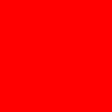

(284.78415445844354, 5.350751932755784e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


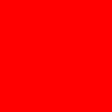

(283.16771715404803, 5.31865916971155e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


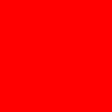

(284.5819639676051, 5.348123549993249e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


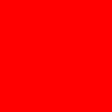

(279.86873181384954, 5.254672568966302e+18)
SPC-Ge26:282.08602479991623,5.30308190731565e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge26  282.086025   5.303082e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


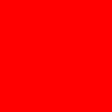

(181.5546095881666, 3.7184518936611436e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


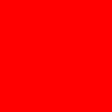

(173.63036125706208, 3.717857595750149e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


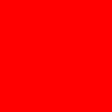

(132.55539217730146, 3.0458291000057124e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


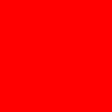

(171.0815075198007, 3.5979626105191014e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


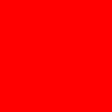

(197.8661805850673, 4.023699340934024e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


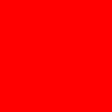

(192.65078718967564, 3.7938432470395146e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


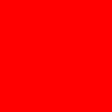

(204.86994958059202, 4.0335539177045407e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


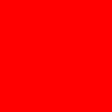

(134.15919946583494, 3.047524245809835e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


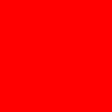

(129.25000521434998, 3.0840400000923366e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


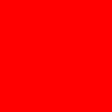

(156.99535476667742, 3.2499281917732925e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


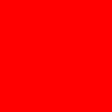

(189.64112685124402, 3.8230136323349166e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


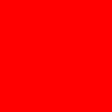

(168.87673509995736, 3.6116661561331876e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


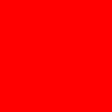

(184.61406557517142, 3.7061642549350784e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


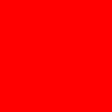

(153.6590620604227, 3.3318306892849295e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


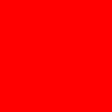

(159.89156543644324, 3.5520369891235144e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


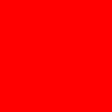

(186.89775197192822, 3.7323072803639373e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


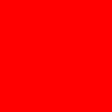

(178.9561806764244, 3.6055303343349166e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


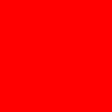

(196.88598426675833, 4.0222649607978225e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


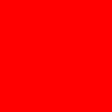

(175.75614095924473, 3.6002280615399347e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


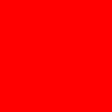

(192.34566679400655, 3.8194645158490163e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


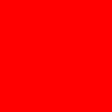

(189.28983288137613, 3.8120400723483617e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


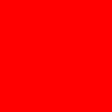

(147.398361622805, 3.177059337905688e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


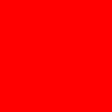

(125.03097361268169, 2.995235040982916e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


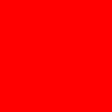

(146.95535830459238, 3.3083071479197875e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


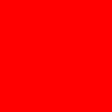

(173.0908454049213, 3.668974902944513e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


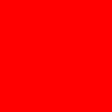

(181.8571787836242, 3.7783493733364705e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


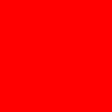

(204.40723745333787, 4.107228160136134e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


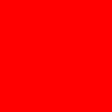

(171.85886767314358, 3.4783599306479913e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


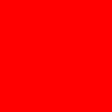

(164.9633829532638, 3.4959033211233137e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


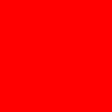

(179.93620376508937, 3.779134486384164e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


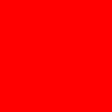

(166.2844007220538, 3.598614130442754e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


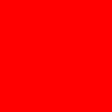

(146.32789691182634, 3.260692576016724e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


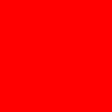

(189.7931122416235, 3.955963571942085e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


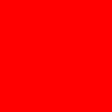

(173.74628338519216, 3.6758622705468314e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


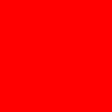

(152.2318781420893, 3.306622365157327e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


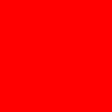

(171.81615869182463, 3.584316962768217e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


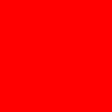

(183.81050050113728, 3.799336785538224e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


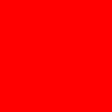

(180.4987906561801, 3.7547630905125673e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


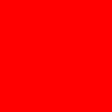

(170.747741240275, 3.4873551634528184e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


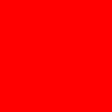

(198.51086257926113, 3.9094461307541627e+18)
SPC-Ge31:172.01733736406067,3.601269045971199e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge26  282.086025   5.303082e+18
0    SPC-Ge31  172.017337   3.601269e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


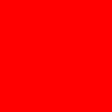

(253.74206367721484, 4.890989281459538e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


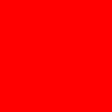

(273.945159885666, 5.187564665129003e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


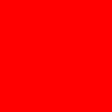

(277.68877847754555, 5.244007422110964e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


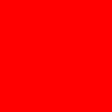

(265.46344281204324, 5.039702083285948e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


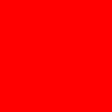

(279.7061794151865, 5.250332482061334e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


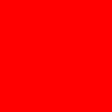

(266.82540576941335, 5.062307706971656e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


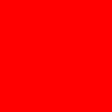

(278.9213231427036, 5.231094621632431e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


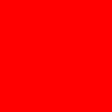

(276.7434328139781, 5.18729026980846e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


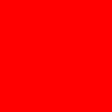

(274.9029938317504, 5.171439321735088e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


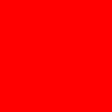

(276.9527414683697, 5.192515270358002e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


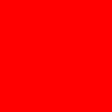

(279.75920343439776, 5.273521139482316e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


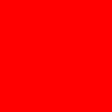

(262.29156078608713, 5.058379438331017e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


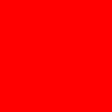

(277.19179837707975, 5.209050855031644e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


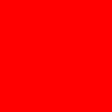

(267.1548255596898, 5.068995473380215e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


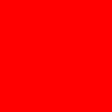

(268.0193674684094, 5.072137953122617e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


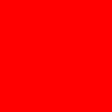

(246.07458892295597, 4.741737376183163e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


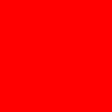

(253.7002365922653, 4.849828181110054e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


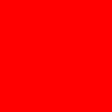

(266.1873852424385, 5.041441046733623e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


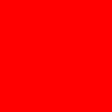

(264.1355745982408, 5.002105418701343e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


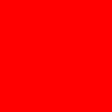

(262.882777812885, 5.023229352712825e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


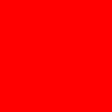

(255.57032933991462, 4.923887433067762e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


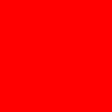

(270.39736953224553, 5.180418897335664e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


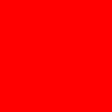

(257.68541604861804, 5.012244303267035e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


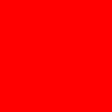

(246.37722111101135, 4.808917145461556e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


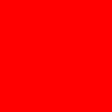

(262.66436672810903, 5.025338456974662e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


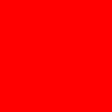

(240.70098961815054, 4.689117905724129e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


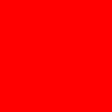

(258.6656753595248, 4.936141279266666e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


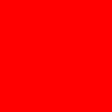

(258.0712929546867, 4.995675827200291e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


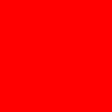

(262.79450943519595, 5.038928684981004e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


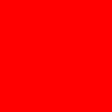

(265.74577563545256, 5.033652545073693e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


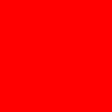

(261.94606213521826, 4.999263692450668e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


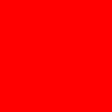

(262.7046189981132, 5.092319526193353e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


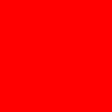

(272.2789899252951, 5.221930088266531e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


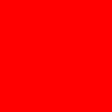

(266.89416218992903, 5.126028022602882e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


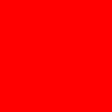

(262.6174844871848, 5.039530417247973e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


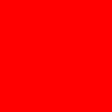

(249.93709029506292, 4.833882839244147e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


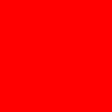

(265.66681441409077, 5.061640191918481e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


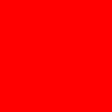

(264.9389506944815, 5.09338939760325e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


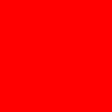

(247.18729017076993, 4.818816328367924e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


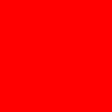

(258.2109790403427, 4.964749807477148e+18)
SPC-Ge39:264.08360570504294,5.042338553726651e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge26  282.086025   5.303082e+18
0    SPC-Ge31  172.017337   3.601269e+18
0    SPC-Ge39  264.083606   5.042339e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


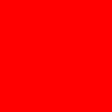

(238.11589938899576, 4.749655641147388e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


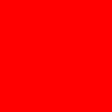

(227.24747152488888, 4.475511286439971e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


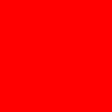

(239.65055655327726, 4.734015783727012e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


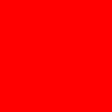

(236.40217001727413, 4.646522875805472e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


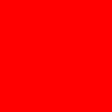

(245.76209839334246, 4.890608327036684e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


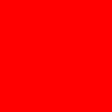

(249.21461244256687, 4.960060981691886e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


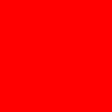

(258.9039448607622, 5.061756888778942e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


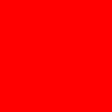

(260.87906201711945, 5.087335353720707e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


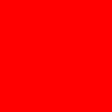

(244.78179183798733, 4.803099649269135e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


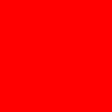

(233.6684330054241, 4.637350006949538e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


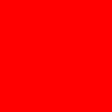

(226.2432435305133, 4.457652386402727e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


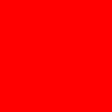

(255.25246869133733, 4.918691944658607e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


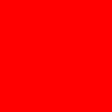

(229.8671131939455, 4.468548448860327e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


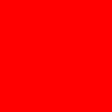

(231.53422804328363, 4.5138160171103437e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


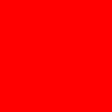

(249.4658269226553, 4.856707663789368e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


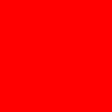

(246.13429015753564, 4.782471113705826e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


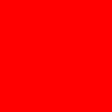

(247.75331015844162, 4.855460043686607e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


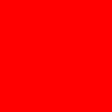

(228.66817507972203, 4.4705678902834324e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


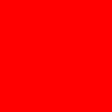

(241.84868325405105, 4.686767522818366e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


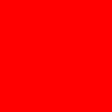

(209.5426459976532, 4.2105828297397376e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


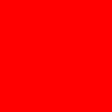

(256.39584733428745, 4.980504784773385e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


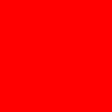

(263.97267574028973, 5.118201222745504e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


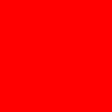

(249.61622174993994, 4.845239381205187e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


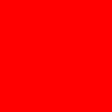

(249.4503937361905, 4.722965852629074e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


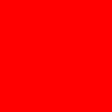

(232.6184093924366, 4.476211467602734e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


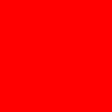

(236.17460925766542, 4.499814196123188e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


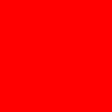

(248.92462601852296, 4.794434569454666e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


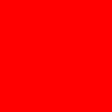

(259.2599790236157, 4.997936772550836e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


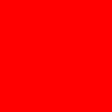

(235.21335796314952, 4.691694473278353e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


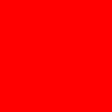

(258.2781763940624, 4.978773706248715e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


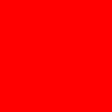

(254.45041543965075, 4.812258550547177e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


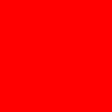

(238.8575427393772, 4.634741449136269e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


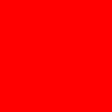

(217.82273951381782, 4.1890725345010555e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


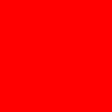

(238.2863731068341, 4.5716100246116925e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


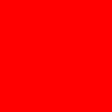

(260.4984134966695, 4.974699453890742e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


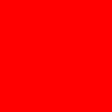

(245.14421974951912, 4.719955163742597e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


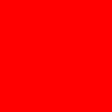

(264.6582241823164, 5.042176146841119e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


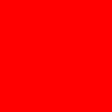

(262.44471153952617, 4.96155844121212e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


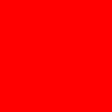

(263.07109418405463, 4.996541366462626e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


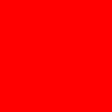

(240.96333803990288, 4.625040290439062e+18)
SPC-Ge37:244.42593484181515,4.747515312590454e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge26  282.086025   5.303082e+18
0    SPC-Ge31  172.017337   3.601269e+18
0    SPC-Ge39  264.083606   5.042339e+18
0    SPC-Ge37  244.425935   4.747515e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


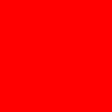

(244.75346091711978, 4.913912554900554e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


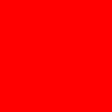

(247.2705663850821, 4.858586528299487e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


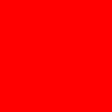

(231.59334659633353, 4.84807795348666e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


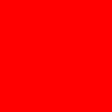

(235.3249021057314, 4.74662692957976e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


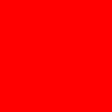

(238.5829265092003, 4.785326807534394e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


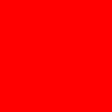

(186.79565671901867, 4.1244860037569516e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


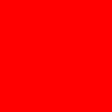

(262.94756569973833, 5.138395862260074e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


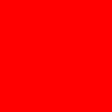

(255.30741398478193, 5.041856018967153e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


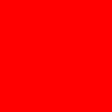

(261.1346072383077, 5.130233164682722e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


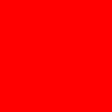

(246.90812272540086, 4.878871281219818e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


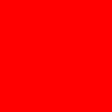

(246.48774162387875, 4.899532933459746e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


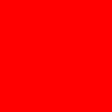

(252.6363546077584, 5.016924117711722e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


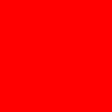

(259.32808977000377, 5.112061796411003e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


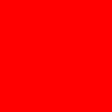

(260.8835344915644, 5.134144762343296e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


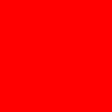

(218.4250589859807, 4.5600079236199547e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


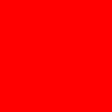

(248.21114035936506, 4.919117054650285e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


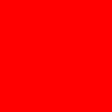

(252.04935808501415, 5.061440590724721e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


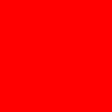

(262.5275153093547, 5.153261645524964e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


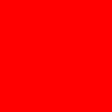

(257.2115384834011, 5.114333555370239e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


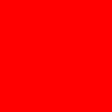

(269.7740262805617, 5.233493215210277e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


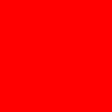

(242.052763522824, 4.889720935273452e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


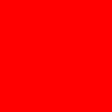

(244.19336223364274, 4.908533685710676e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


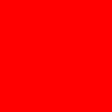

(246.27210221340664, 4.951504037964329e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


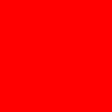

(264.0616842810031, 5.190299832277365e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


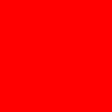

(255.71581074456964, 5.145420427522664e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


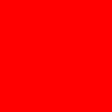

(271.81526991647587, 5.251547436054508e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


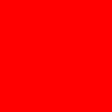

(257.78062936021627, 5.123620868251489e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


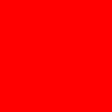

(249.6004893486355, 5.002082665066388e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


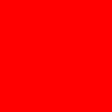

(246.45851305849231, 4.942568617932575e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


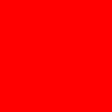

(254.94528528808976, 5.062200472018801e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


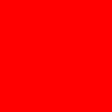

(255.42840701703616, 5.048241004332354e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


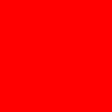

(230.19502116187437, 4.790016083886686e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


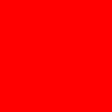

(260.0758276542239, 5.147737468468296e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


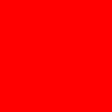

(268.37401579411096, 5.22677481024376e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


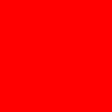

(261.4192707878362, 5.134382436450991e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


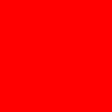

(252.38843149090582, 5.041626229782461e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


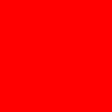

(255.10676681258994, 5.064620918097543e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


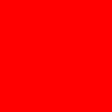

(243.86847791040904, 4.857157554967631e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


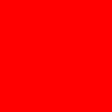

(259.85647168048064, 5.130919603551107e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


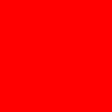

(252.7297568821694, 5.041314662682042e+18)
SPC-Ge38:250.26228210091477,4.990524511256222e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge26  282.086025   5.303082e+18
0    SPC-Ge31  172.017337   3.601269e+18
0    SPC-Ge39  264.083606   5.042339e+18
0    SPC-Ge37  244.425935   4.747515e+18
0    SPC-Ge38  250.262282   4.990525e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


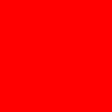

(41.31067526554834, 2.0481409499197896e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


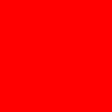

(26.442617541575743, 1.7552440940350303e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


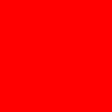

(31.294709495270574, 1.8675911944797507e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


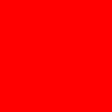

(26.5948263588256, 1.779812894586122e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


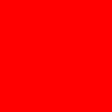

(25.486288774088333, 1.75510485474291e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


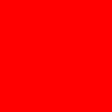

(28.42077015374027, 1.80310353503803e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


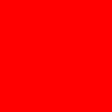

(24.33395509359013, 1.740834678849442e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


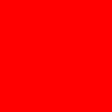

(23.140604004482682, 1.7032191045298465e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


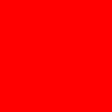

(24.559129762491725, 1.7260071233809027e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


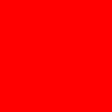

(31.87345398770099, 1.8373246077637043e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


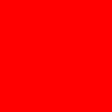

(54.129088208002784, 2.173977393597058e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


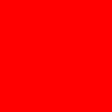

(32.83195132458117, 1.8807818540128596e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


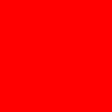

(37.327231058413524, 1.9615814760797384e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


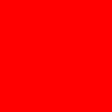

(32.052280130305945, 1.868293910082051e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


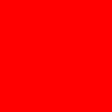

(37.02306342578639, 1.9006217846340032e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


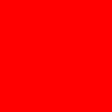

(31.62995511658562, 1.8608547386716424e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


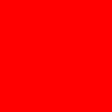

(32.137072104003046, 1.8783425686002255e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


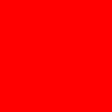

(28.11313792823328, 1.8104005384706312e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


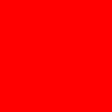

(26.020703456130228, 1.7535552280088714e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


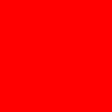

(27.728490854211053, 1.7748358326244004e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


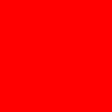

(37.06714938592321, 1.938840034595285e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


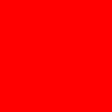

(41.0541260998324, 1.9775735361144448e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


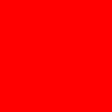

(36.01775274613585, 1.94497168864854e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


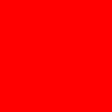

(45.453598029424654, 2.083030157228304e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


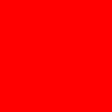

(48.20366980929573, 2.0718090669802993e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


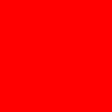

(51.65522518992215, 2.1153664517516065e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


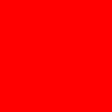

(44.64049548237752, 2.0323581782699633e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


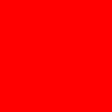

(40.80170294927338, 1.9694190613853683e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


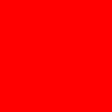

(35.08397016130487, 1.9058476018362844e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


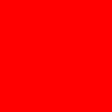

(47.79962347579467, 2.1135876131218831e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


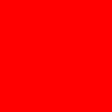

(42.764168436063144, 2.035174222199997e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


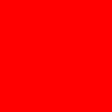

(42.36956508667838, 2.0211065902661967e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


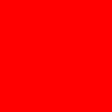

(58.01764883041857, 2.254681382812073e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


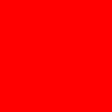

(55.94348762510841, 2.2432391767946824e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


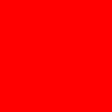

(33.06799147841144, 1.8748577987181268e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


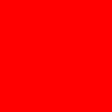

(37.228632878942065, 1.9236434788103736e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


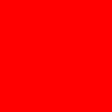

(71.82613414940823, 2.390248103080786e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


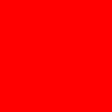

(36.40619561630613, 1.9551626700269379e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


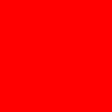

(33.456026865214604, 1.859823784988857e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


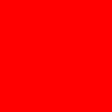

(37.8158144424424, 1.9431757003112824e+18)
SPC-Ge36:37.47807456954613,1.9383386165012076e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge26  282.086025   5.303082e+18
0    SPC-Ge31  172.017337   3.601269e+18
0    SPC-Ge39  264.083606   5.042339e+18
0    SPC-Ge37  244.425935   4.747515e+18
0    SPC-Ge38  250.262282   4.990525e+18
0    SPC-Ge36   37.478075   1.938339e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


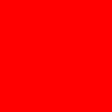

(247.68234899700238, 4.841398072001106e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


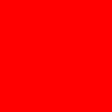

(157.05385914189864, 3.5814141846851384e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


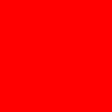

(233.0387275013609, 4.652882629417059e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


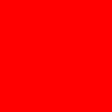

(169.55596853405302, 3.773644777705199e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


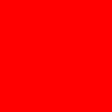

(134.42840620667445, 3.2526359869746555e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


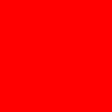

(226.84709057317323, 4.526009712610903e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


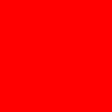

(190.74050516462, 3.9719017047355315e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


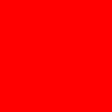

(160.72464254255397, 3.618116248434051e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


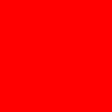

(137.81304573175262, 3.1422638485391657e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


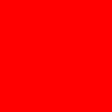

(211.83792303240807, 4.345822100420266e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


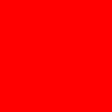

(214.28932722084878, 4.2875709926681943e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


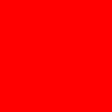

(182.80934339590522, 3.7084342116262e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


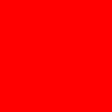

(247.4771978540666, 4.862136320635931e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


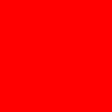

(158.7267378139369, 3.4001933096556933e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


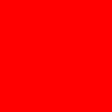

(155.04096217500145, 3.4763731553344737e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


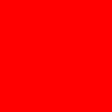

(233.47290398180462, 4.5726064535958953e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


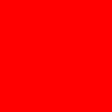

(192.27434342512987, 3.909529035087463e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


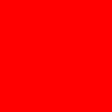

(157.6806669864623, 3.381000055362643e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


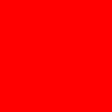

(164.1017387040437, 3.5806734524897823e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


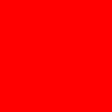

(160.39920703408933, 3.520617147936802e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


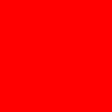

(176.8580862209817, 3.715232817523844e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


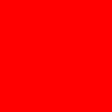

(213.7347403896806, 4.367212094262257e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


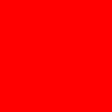

(181.64158661760044, 3.6545824403433836e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


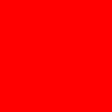

(139.46579039471408, 3.1391917698950134e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


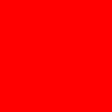

(221.80319452533442, 4.4406126172238515e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


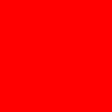

(181.38556895192858, 3.7284326291997256e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


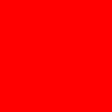

(258.60101345786717, 4.950683555404874e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


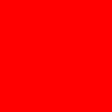

(204.43723767804752, 4.0461614590210575e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


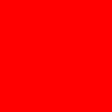

(208.113091982827, 4.1940030894972723e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


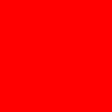

(178.5936897722948, 3.68774530008103e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


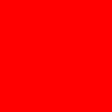

(173.46574585082058, 3.7644110823003766e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


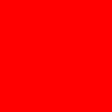

(207.43258294862554, 4.114454579427629e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


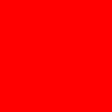

(192.3199658140978, 3.87313651088734e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


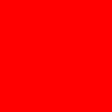

(191.45926645384495, 3.8921240813317407e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


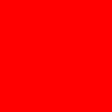

(156.48187060558394, 3.565143758707948e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


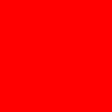

(167.3601725593984, 3.6734098342090445e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


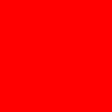

(168.9927359688347, 3.5014687250631173e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


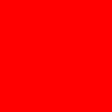

(166.35071617940412, 3.5622772512706883e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


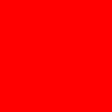

(231.7540092170621, 4.5201732926032727e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/03.極値/01.IPF/(100)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


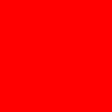

(228.5499064773233, 4.3753790722263834e+18)
SPC-Ge40:189.61989795207643,3.9292764840099005e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge26  282.086025   5.303082e+18
0    SPC-Ge31  172.017337   3.601269e+18
0    SPC-Ge39  264.083606   5.042339e+18
0    SPC-Ge37  244.425935   4.747515e+18
0    SPC-Ge38  250.262282   4.990525e+18
0    SPC-Ge36   37.478075   1.938339e+18
0    SPC-Ge40  189.619898   3.929276e+18


In [11]:
path_list = glob.glob('/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/00.データ/02.テストデータ/NGE44')

ans = {'sample_name':'default',
'mobility':0,
'Concentration':0,
}
d3={}
for k,v in ans.items():   # 一度pd.Seriesに変換
  d3[k]=pd.Series(v)
ans=pd.DataFrame(d3)

for path in path_list:
  preds_list = []
  sample_name = path.split('/')[-1]
  for i in range(4):
    for j in range(10):
      preds = model.predict(path,"cuda:0" if torch.cuda.is_available() else "cpu",mu_range, n_range, [50+int(patch_size*i),int(patch_size*j)])
      img = cv2.imread(f'{path}/{sample_name}_IPF.bmp')
      cv2_imshow(img[int(patch_size*i):int(patch_size*i)+patch_size,int(patch_size*j):int(patch_size*j)+patch_size])
      print(preds)
      preds_list.append(preds)
      sample_name = path.split('/')[-1]
  preds_list = pd.DataFrame(preds_list)

  d1 = {'sample_name':sample_name,
  'mobility':preds_list[0].mean(),
    'Concentration': preds_list[1].mean(),
  }

  d2={}
  for k,v in d1.items():   # 一度pd.Seriesに変換
      d2[k]=pd.Series(v)

  df=pd.DataFrame(d2)
  ans = pd.concat([ans,df])
  print(f'{path.split("/")[-1]}:{preds_list[0].mean()},{preds_list[1].mean()}')

  #preds_list = pd.DataFrame(preds_list)
  #preds_list.to_csv(f'/content/drive/MyDrive/03.移動度ML/10.論文用/02.After0721/02.TestData/{sample_name}_preds.csv')
  print(ans)

In [34]:
#NGE18
preds_list.describe()

0             1
count   40.000000  4.000000e+01
mean   194.739346  3.773850e+18
std     16.249760  4.178339e+17
min    170.164839  3.157055e+18
25%    183.638680  3.427555e+18
50%    192.393029  3.741392e+18
75%    205.071951  4.086484e+18
max    249.354157  4.852490e+18

In [36]:
#NGE44
preds_list.describe()

0             1
count   40.000000  4.000000e+01
mean   139.727002  2.836697e+18
std     30.967245  3.206622e+17
min     37.380468  1.882689e+18
25%    126.172506  2.663095e+18
50%    150.320742  2.923714e+18
75%    160.102362  3.010289e+18
max    173.595621  3.261328e+18

['/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40']
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB

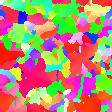

(21.58537980507397, 1.6209072598324298e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


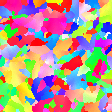

(21.583209386350173, 1.6184050604783437e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


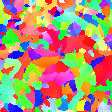

(21.593882731167795, 1.6224579637032717e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


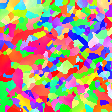

(21.575591480495742, 1.6094337605268667e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


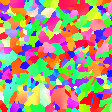

(21.57910965159049, 1.6140995862733312e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


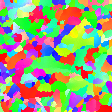

(21.576716969517737, 1.609666085911122e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


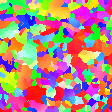

(21.578256105542614, 1.6121353146708698e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


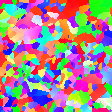

(21.576906138588143, 1.609286358227404e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


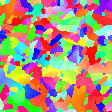

(21.577416923529494, 1.6104570281697505e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


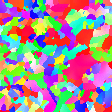

(21.586259390740793, 1.6194483009128013e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


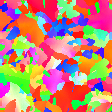

(21.587900178936554, 1.6215439620849283e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


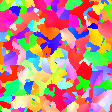

(21.62360625597025, 1.6381179734380232e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


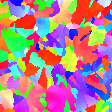

(21.694028400853643, 1.6354570090472166e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


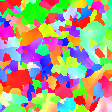

(21.584844580415695, 1.6155213892533304e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


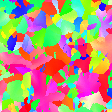

(21.605191584559524, 1.619677083361787e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


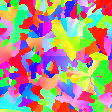

(21.57955053825899, 1.6127264744529096e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


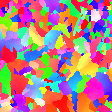

(21.597122678387386, 1.6236764447914678e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


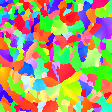

(21.577376030149097, 1.6129400749050575e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


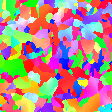

(21.579211144203704, 1.6133005496484314e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


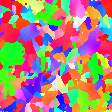

(21.583640137262083, 1.615331116205088e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


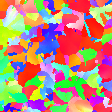

(21.576704887590147, 1.6089881198149115e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


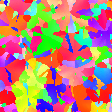

(21.60769824895826, 1.6288267990565335e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


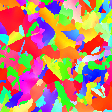

(21.578953616207453, 1.6110955221301993e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


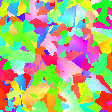

(21.61763368570508, 1.6363636555108204e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


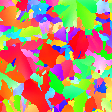

(21.67930513450701, 1.6420652855757394e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


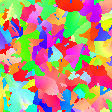

(21.595885864251272, 1.624734161451753e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


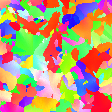

(21.61181093047692, 1.6318815907110103e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


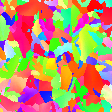

(21.61438088928737, 1.6261336648838815e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


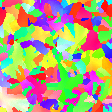

(21.5886563438647, 1.620889022427928e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


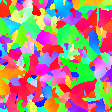

(21.5749665685692, 1.6062562183974938e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


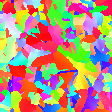

(21.585059001889817, 1.6213301134689088e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


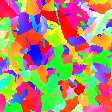

(21.590395884799406, 1.6265226027912778e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


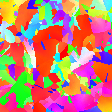

(21.596645777823397, 1.6243838667071862e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


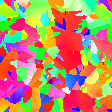

(21.582766538852518, 1.6199135307303447e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


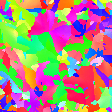

(21.579357733003928, 1.6141126527171666e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


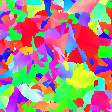

(21.603122340775396, 1.6328873267204022e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


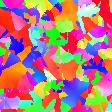

(21.611966355023227, 1.636090428848509e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


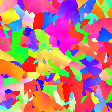

(21.579802235672076, 1.6157574986966167e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


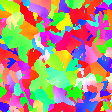

(21.591130042303853, 1.6222150464737846e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge36/SPC-Ge36_IPF.bmp'}


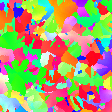

(21.606293614759764, 1.6312425564221325e+18)
SPC-Ge36:21.59494339514787,1.620906961485776e+18
  sample_name   mobility  Concentration
0     default   0.000000   0.000000e+00
0    SPC-Ge36  21.594943   1.620907e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


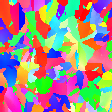

(30.276992226628394, 1.960457508465944e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


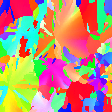

(32.37355419027737, 1.9748688104009656e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


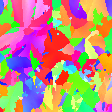

(29.100595619829484, 1.9692870452459284e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


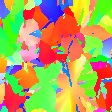

(23.936170125886, 1.7781191286435246e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


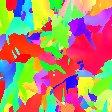

(23.480343138786044, 1.77970268870692e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


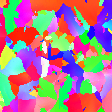

(62.54621030960305, 2.517731200285702e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


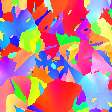

(56.61844543662736, 2.3751465042971955e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


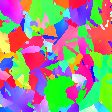

(45.24387795462854, 2.2294503613703946e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


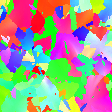

(42.89100206324609, 2.1995216154446346e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


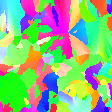

(34.15929197537692, 1.9818637227209723e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


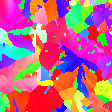

(25.336653302885175, 1.8578687746508708e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


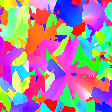

(32.678616514645356, 2.015072934541707e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


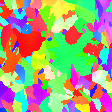

(30.99599859642921, 1.9408140250693599e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


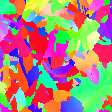

(22.285186795015026, 1.706160075208726e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


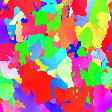

(45.908117181925434, 2.2520294016014031e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


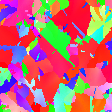

(38.16651391966842, 2.11320739087045e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


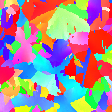

(68.18335883255666, 2.490180265533584e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


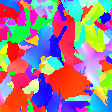

(31.998838785134176, 2.048683122857639e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


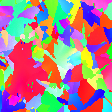

(26.35113408074975, 1.8529308416195569e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


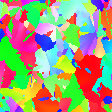

(36.96643800164691, 2.1412514712355958e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


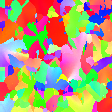

(29.96459815443028, 1.9505014696326287e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


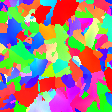

(34.691942618615144, 2.0458675013341952e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


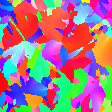

(28.457208910928216, 2.0583041651050378e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


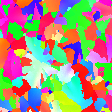

(25.998192460745237, 1.852053784737548e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


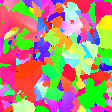

(30.441406843964355, 1.9845626473839557e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


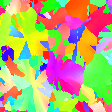

(38.61962361279308, 2.1299743980342623e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


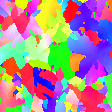

(24.08632774666949, 1.8231588930198213e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


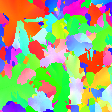

(43.41909066443939, 2.1988955525581097e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


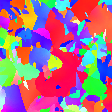

(29.35841103518745, 1.9786380288804367e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


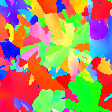

(44.8982139481904, 2.2352698851144448e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


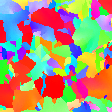

(26.412303338136347, 1.8400693494614295e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


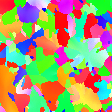

(26.973318367059704, 1.878512066284374e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


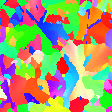

(23.671861059526655, 1.816613463551707e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


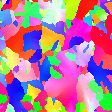

(41.295783421721005, 2.2195452084508948e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


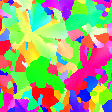

(21.874280419972944, 1.6860223972227502e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


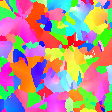

(23.996046066498696, 1.7859341433570552e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


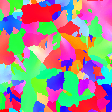

(43.92763778067909, 2.137390787649277e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


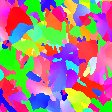

(33.311186213390485, 2.0381570885724454e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


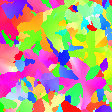

(24.884703067264063, 1.838222080964206e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge31/SPC-Ge31_IPF.bmp'}


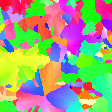

(52.79374749728446, 2.2496084486347533e+18)
SPC-Ge31:34.714330556976044,2.02329120621801e+18
  sample_name   mobility  Concentration
0     default   0.000000   0.000000e+00
0    SPC-Ge36  21.594943   1.620907e+18
0    SPC-Ge31  34.714331   2.023291e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


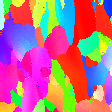

(125.54993812978515, 3.1560464686668073e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


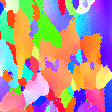

(52.61388000829686, 2.213513580278035e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


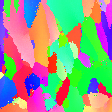

(86.35203429084456, 2.764012940498825e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


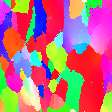

(151.37776150830817, 3.4929408429089183e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


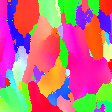

(198.09898547844412, 4.140356551496077e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


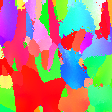

(180.8114859117365, 3.9385610963050214e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


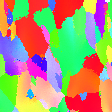

(200.97992044323965, 4.1473554344380247e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


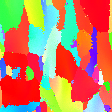

(156.39924006539937, 3.6204353169313116e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


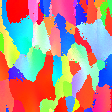

(128.0350827284308, 3.2706371535512443e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


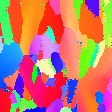

(76.15537917502957, 2.592837907943625e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


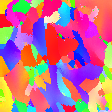

(51.360508415486024, 2.176841197632145e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


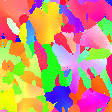

(61.37926456099515, 2.2798653763201193e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


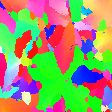

(92.12389248422673, 2.7458383056161464e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


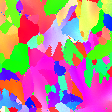

(164.14399098902848, 3.7224518024593633e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


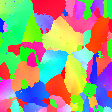

(195.3292481969425, 4.126790654109291e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


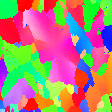

(74.41857876435799, 2.63125043677564e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


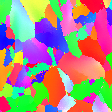

(39.92534992846336, 2.1683011501681682e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


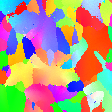

(99.33188348186948, 2.9711913199830185e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


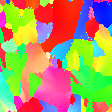

(71.66127464685022, 2.548922266063539e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


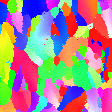

(55.76545085849484, 2.3248704329549783e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


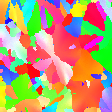

(80.3779619843997, 2.65574280989447e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


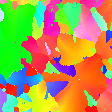

(175.40092570016282, 3.833918030282549e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


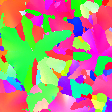

(123.67590834477238, 3.1509606933291663e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


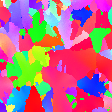

(167.07963502502682, 3.715793548191192e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


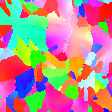

(84.32008206310817, 2.660904956343493e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


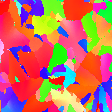

(77.5346178523506, 2.563881204061634e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


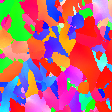

(123.46092248250261, 3.134561405181738e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


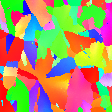

(104.49356781354865, 2.901739453820117e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


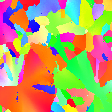

(49.81019955916607, 2.2477041270875075e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


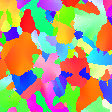

(124.05941515434822, 3.251608919432493e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


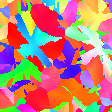

(149.91635686121148, 3.4132853231699333e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


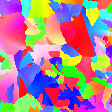

(169.59796884864656, 3.6037107193890857e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


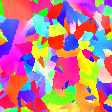

(47.635195078827934, 2.1661182655553633e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


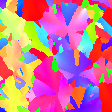

(151.9122615748479, 3.4740304320682004e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


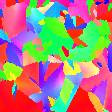

(186.57680468605795, 3.915607184306047e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


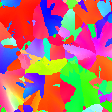

(97.72165094835881, 2.8283612339264486e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


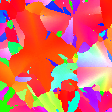

(196.87582671036057, 4.0567799721889137e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


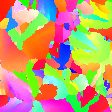

(127.57561471996416, 3.2603948638524406e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


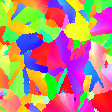

(129.98853043113957, 3.211931648950622e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge37/SPC-Ge37_IPF.bmp'}


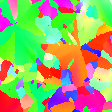

(64.51604002478119, 2.3862620492187023e+18)
SPC-Ge37:117.3585658982453,3.08665792688376e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   21.594943   1.620907e+18
0    SPC-Ge31   34.714331   2.023291e+18
0    SPC-Ge37  117.358566   3.086658e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


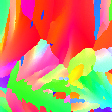

(176.48813069401092, 3.8635461916792177e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


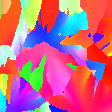

(227.89670473427492, 4.5671949182964285e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


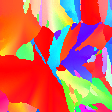

(223.4514745879257, 4.4485389923945953e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


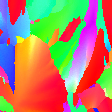

(241.09713431766312, 4.794195543645884e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


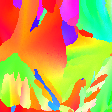

(193.2050590578547, 4.113650091997697e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


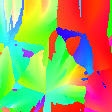

(214.49808469000953, 4.3563266201298345e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


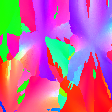

(221.19153640054537, 4.4846735669707274e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


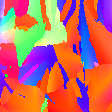

(208.4327321722926, 4.3388694005987707e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


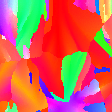

(221.66731949184626, 4.4392237443575593e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


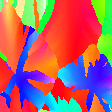

(212.6864648212825, 4.363003572929701e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


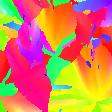

(238.58946199122366, 4.774965342856473e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


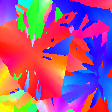

(200.24659211576986, 4.1221464344598794e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


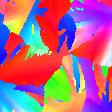

(214.26705933752098, 4.41859678577885e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


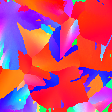

(233.56288890778413, 4.703528616289925e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


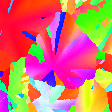

(198.656060517226, 4.0808485870171525e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


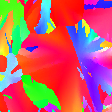

(257.60236030839826, 5.000793592796976e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


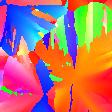

(204.7175704864762, 4.232508322495464e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


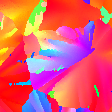

(251.2860295328347, 4.903045554016312e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


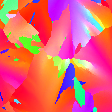

(226.8874373320741, 4.5696541131396485e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


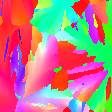

(246.71933390974763, 4.944702503380997e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


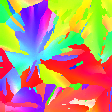

(173.53196681927417, 3.7584617952520305e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


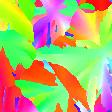

(219.32944371281863, 4.437944133995752e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


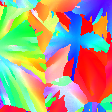

(229.07298126143425, 4.609759985507671e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


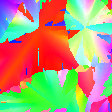

(235.2880829323082, 4.734203219610995e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


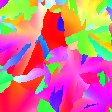

(214.23820872772146, 4.464868217369045e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


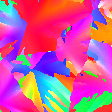

(206.95555575351779, 4.3308907596526853e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


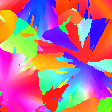

(211.9328528773161, 4.3916053426347505e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


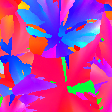

(239.21869505080326, 4.701934510142012e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


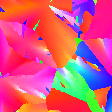

(238.94872452471523, 4.781633284315763e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


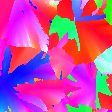

(232.24783968763714, 4.657655035386165e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


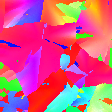

(224.19779513869494, 4.483599189890541e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


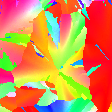

(253.4542347496461, 4.891845584097784e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


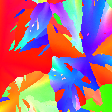

(207.66658470136088, 4.226945847241347e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


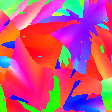

(210.57602381666794, 4.34827025637128e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


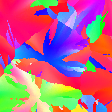

(196.13108097453673, 3.9546954510395126e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


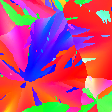

(220.02233079249083, 4.4540658728534364e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


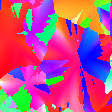

(229.89752287054094, 4.687982702095055e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


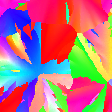

(213.322044385092, 4.3528088180524365e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


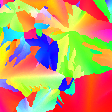

(241.48198759401726, 4.797007532472659e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge26/SPC-Ge26_IPF.bmp'}


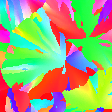

(208.98755522570252, 4.313656120233852e+18)
SPC-Ge26:220.49127367507646,4.4724961538361713e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   21.594943   1.620907e+18
0    SPC-Ge31   34.714331   2.023291e+18
0    SPC-Ge37  117.358566   3.086658e+18
0    SPC-Ge26  220.491274   4.472496e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


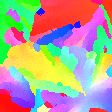

(144.78201131698424, 3.7498142875516836e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


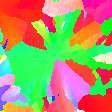

(32.02888822281088, 1.9645422928282148e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


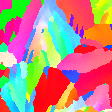

(50.3820660473225, 2.2281048555806246e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


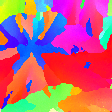

(95.15448211328257, 2.923905887294497e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


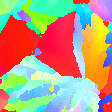

(161.33278883001478, 3.800248733204526e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


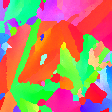

(25.198734700940545, 1.7846683316105052e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


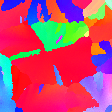

(186.02470606250353, 4.15001445575852e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


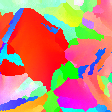

(54.9364170897564, 2.3424109510654925e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


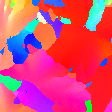

(174.88377222024656, 3.8765123843506637e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


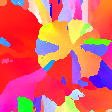

(67.80537962343914, 2.500358799997811e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


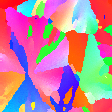

(95.45086228600476, 3.0801946357849974e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


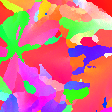

(104.09360418779352, 3.147519149721394e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


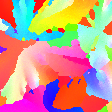

(239.3049476653622, 4.906897226262055e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


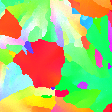

(116.54594942767363, 3.106053803985709e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


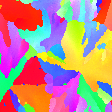

(30.864913953153064, 1.910506971802039e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


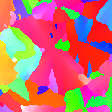

(25.945432715167016, 1.8222480717710912e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


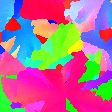

(172.41176945232016, 4.0189859592456914e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


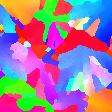

(188.1521078240799, 4.207266431124216e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


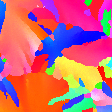

(62.78733022589154, 2.446566897808947e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


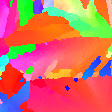

(70.03503805645701, 2.4645863686710815e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


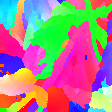

(63.558036786090135, 2.440020215201284e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


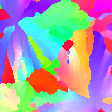

(135.03896196100172, 3.4184425133816397e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


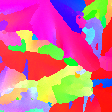

(46.174410515115966, 2.1651884078496663e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


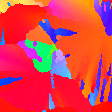

(174.32203572922634, 3.9200065207753027e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


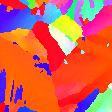

(144.44463871123358, 3.520911593490126e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


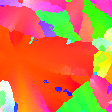

(77.4017664635576, 2.671652782248616e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


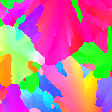

(183.4813326812521, 4.0716649045525274e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


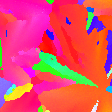

(33.35264518534653, 1.9870383724050447e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


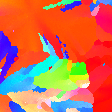

(65.2505415893853, 2.493138238077691e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


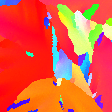

(48.77438471402335, 2.2839827704711e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


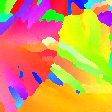

(107.12025677948589, 3.097989330020636e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


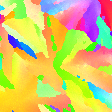

(49.53684711798283, 2.2696213406740795e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


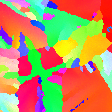

(38.21190599195057, 2.057571712078836e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


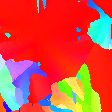

(110.59161348953188, 3.1173381425803817e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


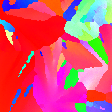

(166.82997961173433, 3.886594497470727e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


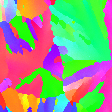

(65.7041001047694, 2.421962558783459e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


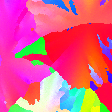

(162.91891094671155, 3.7098097927651425e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


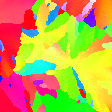

(107.84284486902811, 3.26502466535693e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


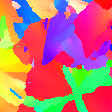

(41.537875786238274, 2.1487144382172134e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge38/SPC-Ge38_IPF.bmp'}


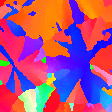

(47.80303295015143, 2.2236272894109926e+18)
SPC-Ge38:99.20043310012552,2.940042664530779e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   21.594943   1.620907e+18
0    SPC-Ge31   34.714331   2.023291e+18
0    SPC-Ge37  117.358566   3.086658e+18
0    SPC-Ge26  220.491274   4.472496e+18
0    SPC-Ge38   99.200433   2.940043e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


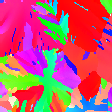

(198.67620240037752, 4.1018709181636383e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


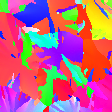

(211.377226668284, 4.305379654481726e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


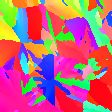

(216.32538971559262, 4.3842189720480297e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


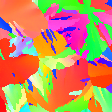

(190.46658185301905, 4.0893708370834913e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


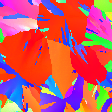

(200.57591741714958, 4.1471091995567826e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


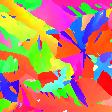

(189.34898293072493, 4.030662629080697e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


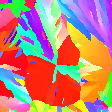

(207.71086849762523, 4.243589117434874e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


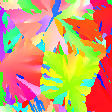

(209.61179612190523, 4.3297298737029683e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


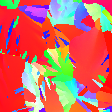

(203.50708897870302, 4.1361464531789194e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


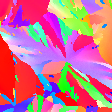

(201.32182851603304, 4.194138935456457e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


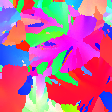

(210.46597574828417, 4.3448394137304417e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


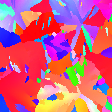

(169.40780994399086, 3.655040667011678e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


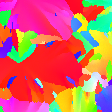

(232.4396206516866, 4.627793029701548e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


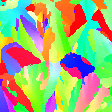

(206.55854490578525, 4.1909245902729595e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


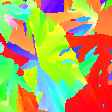

(200.41766426328746, 4.1337429033637576e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


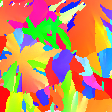

(184.85192562452298, 3.8749766266329805e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


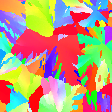

(209.78568718817507, 4.2871961209002286e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


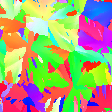

(170.74552075120198, 3.74587813398804e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


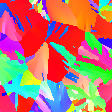

(196.15938039910534, 4.0216992738931574e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


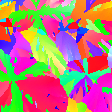

(182.51362464546008, 3.781567998906741e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


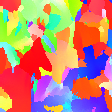

(211.60974809497066, 4.285958863839129e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


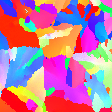

(200.79996633943006, 4.182422841006431e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


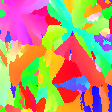

(197.06100919978886, 4.117614406000641e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


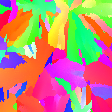

(197.89973989155354, 4.066688166435858e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


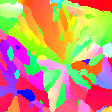

(141.2888670421688, 3.3290679249060516e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


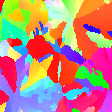

(207.873168925897, 4.2540801201335777e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


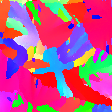

(202.3014736491111, 4.1987831551058683e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


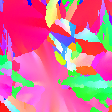

(219.39309773291126, 4.4667295097650396e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


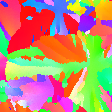

(186.09169869028037, 3.9559372137709e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


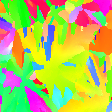

(169.74913533525444, 3.6703867547292744e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


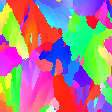

(190.0498700703197, 4.116011063228637e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


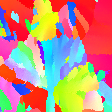

(161.24283540033417, 3.714361646173649e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


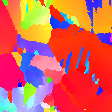

(200.54150771059284, 4.211242685153423e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


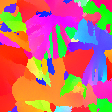

(177.38966500579772, 3.8582937065409193e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


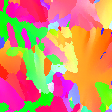

(165.44132354103985, 3.648640812934527e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


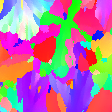

(191.06664933981006, 4.000405476111816e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


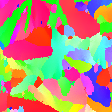

(168.01231917643338, 3.7364802069012183e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


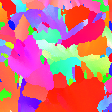

(222.98172303786563, 4.4851356234587674e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


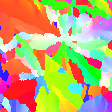

(134.2176959669814, 3.3425055233313853e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge39/SPC-Ge39_IPF.bmp'}


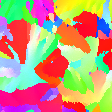

(200.97162116847747, 4.186166377165261e+18)
SPC-Ge39:193.4562688134983,4.061319685632038e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   21.594943   1.620907e+18
0    SPC-Ge31   34.714331   2.023291e+18
0    SPC-Ge37  117.358566   3.086658e+18
0    SPC-Ge26  220.491274   4.472496e+18
0    SPC-Ge38   99.200433   2.940043e+18
0    SPC-Ge39  193.456269   4.061320e+18
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


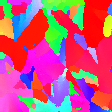

(62.48884767521726, 2.326931326544734e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


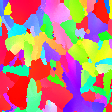

(24.18663681494021, 1.8058231998645583e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


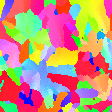

(24.90414464989456, 1.8477577689200855e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


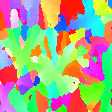

(26.109776957960108, 1.8804575302334377e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


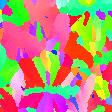

(22.839758739260645, 1.7100390349201505e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


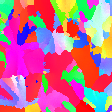

(67.12317372613404, 2.4892222473885865e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


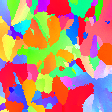

(22.534606539711596, 1.730415963998422e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


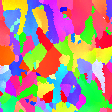

(21.772426848868722, 1.6655572696485903e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


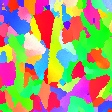

(23.643711980572334, 1.7357366818811453e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


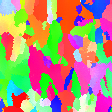

(34.534275099060835, 2.0457000030412367e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


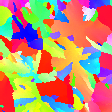

(25.80933179416013, 1.8347846769410107e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


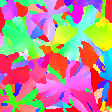

(24.22888663927664, 1.7659371338054945e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


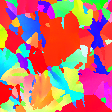

(55.61841038704387, 2.2747092562051067e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


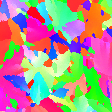

(38.74591196030117, 2.1013808511774884e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


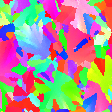

(21.96740270335959, 1.6738954842039916e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


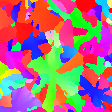

(38.50724875532749, 2.0488915382689009e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


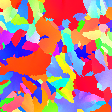

(23.702202576162758, 1.7794366570368497e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


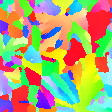

(21.890095222239072, 1.6812658315007503e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


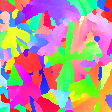

(21.89957440864424, 1.6653838506232689e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


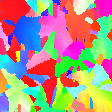

(28.582446069460268, 1.8904953469824814e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


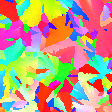

(28.574323469249755, 1.858136495947299e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


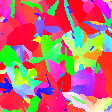

(55.062996778029394, 2.2491225684150653e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


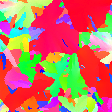

(24.915182134143052, 1.7893718993857418e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


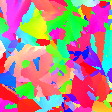

(22.989468891141293, 1.725105707718899e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


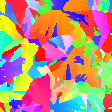

(36.28358052465815, 2.0355938690664504e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


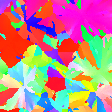

(35.60084903286503, 1.9838336580917878e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


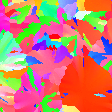

(42.9773885370754, 2.1368559082652065e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


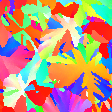

(57.84398611231581, 2.3210078344587873e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


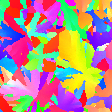

(39.507752312357226, 2.0607642047614364e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


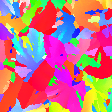

(26.059764772331917, 1.8736892812893596e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


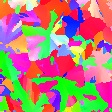

(21.957483522270945, 1.6961364231606505e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


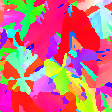

(33.17814978384139, 1.9457803438234883e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


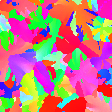

(43.031904693447395, 2.087207983682023e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


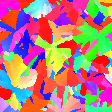

(25.809793411791, 1.774761742508601e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


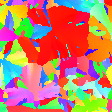

(23.7431256189077, 1.8036526776846065e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


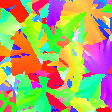

(22.852816169741438, 1.74161879220154e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


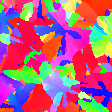

(31.21590969244068, 1.974556623770882e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


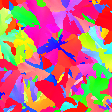

(21.80424203242389, 1.656456181752433e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


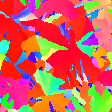

(25.016103411723794, 1.8062154325433528e+18)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/SPC-Ge40/SPC-Ge40_IPF.bmp'}


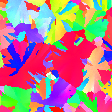

(33.57650020853686, 1.9690047650023818e+18)
SPC-Ge40:32.077254766422186,1.9110673511679073e+18
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   21.594943   1.620907e+18
0    SPC-Ge31   34.714331   2.023291e+18
0    SPC-Ge37  117.358566   3.086658e+18
0    SPC-Ge26  220.491274   4.472496e+18
0    SPC-Ge38   99.200433   2.940043e+18
0    SPC-Ge39  193.456269   4.061320e+18
0    SPC-Ge40   32.077255   1.911067e+18


In [26]:
path_list = glob.glob('/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/01.n型/03.極値/03.GB/06.一面HAGB(blue)/*')
name_list = ['SPC-Ge36',
'SPC-Ge31',
'SPC-Ge37',
'SPC-Ge26',
'SPC-Ge38',
'SPC-Ge39',
'SPC-Ge40',
]

path_list_sorted = []
for i in range(len(name_list)):
  for path in path_list:
    if name_list[i] in path:
      path_list_sorted.append(path)
print(path_list_sorted)
path_list = path_list_sorted

ans = {'sample_name':'default',
'mobility':0,
'Concentration':0,
}
d3={}
for k,v in ans.items():   # 一度pd.Seriesに変換
  d3[k]=pd.Series(v)
ans=pd.DataFrame(d3)

for path in path_list:
  preds_list = []
  sample_name = path.split('/')[-1]
  for i in range(4):
    for j in range(10):
      preds = model.predict(path,"cuda:0" if torch.cuda.is_available() else "cpu",mu_range, n_range, [50+int(patch_size*i),int(patch_size*j)])
      img = cv2.imread(f'{path}/{sample_name}_IPF.bmp')
      cv2_imshow(img[int(patch_size*i):int(patch_size*i)+patch_size,int(patch_size*j):int(patch_size*j)+patch_size])
      print(preds)
      preds_list.append(preds)
      sample_name = path.split('/')[-1]
  preds_list = pd.DataFrame(preds_list)

  d1 = {'sample_name':sample_name,
  'mobility':preds_list[0].mean(),
    'Concentration': preds_list[1].mean(),
  }

  d2={}
  for k,v in d1.items():   # 一度pd.Seriesに変換
      d2[k]=pd.Series(v)

  df=pd.DataFrame(d2)
  ans = pd.concat([ans,df])
  print(f'{path.split("/")[-1]}:{preds_list[0].mean()},{preds_list[1].mean()}')

  #preds_list = pd.DataFrame(preds_list)
  #preds_list.to_csv(f'/content/drive/MyDrive/03.移動度ML/10.論文用/02.After0721/02.TestData/{sample_name}_preds.csv')
  print(ans)

In [14]:
#100
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   37.478075   1.938339e+18
0    SPC-Ge31  172.017337   3.601269e+18
0    SPC-Ge37  244.425935   4.747515e+18
0    SPC-Ge26  282.086025   5.303082e+18
0    SPC-Ge38  250.262282   4.990525e+18
0    SPC-Ge39  264.083606   5.042339e+18
0    SPC-Ge40  189.619898   3.929276e+18

In [16]:
#110
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36  104.514082   2.752650e+18
0    SPC-Ge31  154.921311   3.259353e+18
0    SPC-Ge37  205.002169   4.046487e+18
0    SPC-Ge26  246.822748   4.756170e+18
0    SPC-Ge38  242.123240   4.844618e+18
0    SPC-Ge39  230.230244   4.476754e+18
0    SPC-Ge40  166.247585   3.456146e+18

In [19]:
#111
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36  188.717182   3.849125e+18
0    SPC-Ge31  259.745720   5.084058e+18
0    SPC-Ge37  270.801364   5.229215e+18
0    SPC-Ge26  285.132236   5.367502e+18
0    SPC-Ge38  261.258968   5.169985e+18
0    SPC-Ge39  281.110209   5.332754e+18
0    SPC-Ge40  266.705028   5.174973e+18

In [25]:
#White
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36  243.180251   5.031608e+18
0    SPC-Ge31  281.983662   5.346541e+18
0    SPC-Ge37  285.737971   5.372510e+18
0    SPC-Ge26  285.783138   5.373066e+18
0    SPC-Ge38  285.783067   5.373065e+18
0    SPC-Ge39  285.740698   5.372601e+18
0    SPC-Ge40  278.779177   5.323945e+18

In [23]:
#Gray
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36  149.728247   3.022321e+18
0    SPC-Ge31  195.975745   3.864764e+18
0    SPC-Ge37  215.815258   4.348768e+18
0    SPC-Ge26  259.351680   5.064327e+18
0    SPC-Ge38  267.538013   5.182455e+18
0    SPC-Ge39  223.447742   4.407498e+18
0    SPC-Ge40  189.682043   3.639679e+18

In [21]:
#Black
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   36.265959   1.923640e+18
0    SPC-Ge31   88.733152   2.516841e+18
0    SPC-Ge37  163.404054   3.535241e+18
0    SPC-Ge26  244.061408   4.865314e+18
0    SPC-Ge38  252.811975   5.008537e+18
0    SPC-Ge39  199.656724   4.081070e+18
0    SPC-Ge40  111.876006   2.807654e+18

In [28]:
#woLAGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   22.589691   1.645734e+18
0    SPC-Ge31  202.347138   4.136285e+18
0    SPC-Ge37  214.562829   4.433294e+18
0    SPC-Ge26  278.388622   5.275378e+18
0    SPC-Ge38  259.841827   5.111078e+18
0    SPC-Ge39  222.104051   4.674744e+18
0    SPC-Ge40  177.428244   3.341097e+18

In [30]:
#woHAGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36  245.414827   4.903588e+18
0    SPC-Ge31  239.716704   4.858182e+18
0    SPC-Ge37  264.855354   5.174027e+18
0    SPC-Ge26  285.783137   5.373066e+18
0    SPC-Ge38  266.586104   5.223189e+18
0    SPC-Ge39  284.059525   5.360728e+18
0    SPC-Ge40  250.578202   5.027160e+18

In [33]:
#allLAGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36  258.591422   5.111673e+18
0    SPC-Ge31  273.681392   5.267266e+18
0    SPC-Ge37  281.505210   5.347378e+18
0    SPC-Ge26  285.783138   5.373066e+18
0    SPC-Ge38  266.513219   5.234336e+18
0    SPC-Ge39  285.760277   5.372936e+18
0    SPC-Ge40  272.861018   5.271240e+18

In [35]:
#allHAGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   22.193338   1.633919e+18
0    SPC-Ge31  201.270285   4.110762e+18
0    SPC-Ge37  212.828989   4.383609e+18
0    SPC-Ge26  257.995532   5.041232e+18
0    SPC-Ge38  256.579916   5.039629e+18
0    SPC-Ge39  217.535025   4.596809e+18
0    SPC-Ge40  166.584267   3.147256e+18

In [27]:
#一面HAGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36   21.594943   1.620907e+18
0    SPC-Ge31   34.714331   2.023291e+18
0    SPC-Ge37  117.358566   3.086658e+18
0    SPC-Ge26  220.491274   4.472496e+18
0    SPC-Ge38   99.200433   2.940043e+18
0    SPC-Ge39  193.456269   4.061320e+18
0    SPC-Ge40   32.077255   1.911067e+18

In [23]:
#一面LAGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36  258.591422   5.111673e+18
0    SPC-Ge31  273.681392   5.267266e+18
0    SPC-Ge37  281.505210   5.347378e+18
0    SPC-Ge26  285.783138   5.373066e+18
0    SPC-Ge38  266.513219   5.234336e+18
0    SPC-Ge39  285.760277   5.372936e+18
0    SPC-Ge40  272.861018   5.271240e+18

In [21]:
#woGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0    SPC-Ge36  245.672510   4.900310e+18
0    SPC-Ge31  238.656238   4.840401e+18
0    SPC-Ge37  263.794885   5.157460e+18
0    SPC-Ge26  285.783020   5.373063e+18
0    SPC-Ge38  267.896905   5.226804e+18
0    SPC-Ge39  282.938629   5.349529e+18
0    SPC-Ge40  247.073010   4.970168e+18